In [1]:
from dotenv import load_dotenv
from helpers.utils import Utils

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle
from ipywidgets import interactive, VBox, Layout, HBox, HTML

from models.peer import Peer
from models.data_model import DataModel
from models.interactive_parameter import InteractiveParameter, IntParameter, FloatParameter, IntRangeParameter

from inspect import getargspec

%config InlineBackend.figure_format = 'retina'

### Set default parameters for status quo graphs

In [2]:
use_snapshot = True
default_snapshot = "2024_04_19"

min_version = "2.0.7"
token_price = 0.111
target_apr = 10.4
min_stake_wxhopr = 10_000
thrs_stake_wxhopr = 75_000
transformation_slope = 1.0
transformation_flattening_factor = 1.4

In [3]:
class StakeModel(DataModel):
    def __init__(self, use_snapshot: bool):
        self.peers = []
        self.topology = []
        self.safe = []
        super().__init__(use_snapshot)
    
    async def get_dynamic_data(self):
        self.safes = await Utils.getSafesData()
        self.topology = await Utils.getTopologyData()
        self.peers = await Utils.getPeers()

    def load_snapshot(self, folder: str):
        self.peers, self.safes, self.topology = Utils.loadSnapshot(folder, "peers", "safes", "topology")
 
    def dump_snapshot(self, folder: str):
        Utils.dumpSnapshot(peers=self.peers, safes=self.safes, topology=self.topology)

    def plot_static(self, ax: plt.Axes, peers: list[Peer], bin: list[int], limits: list[int], token_price: float, watermark: str):
        stakes = [peer.split_stake for peer in peers]
        rewards = [peer.rewards for peer in peers]

        apr = sum(rewards) / sum(stakes) * 12 if sum(stakes) > 0 else 0
    
        texts = [
            f"Stakes: {sum(stakes):_.0f} wxHOPR",
            f"Rewards: {sum(rewards):_.0f} wxHOPR -> Budget: {sum(rewards)*token_price:_.0f} $",
            f"APR (avg.): {apr:.2%}",
            f"Peers: {len(peers)}"
        ]

        # plot
        counts, _, bars = ax.hist(stakes, bins=bin, facecolor="#000050", edgecolor='black', linewidth=1.2, rwidth=.85)
        max_height = max(round(counts.max() / 20 + .5) * 20, 1)
        areas = [
            (((0, 0), limits[0], max_height), "#ff0000"),
            (((limits[0], 0), limits[1]-limits[0], max_height), "#ffffa0")
        ]

        # settings
        ax.bar_label(bars)
        ax.set_xlim(bin[0], bin[-1])
        ax.set_ylim(0, max_height)
        ax.set_xlabel("Stake (wxHOPR)")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        [ax.add_patch(Rectangle(*loc, color=color, alpha=.4, zorder=0)) for loc, color in areas]

        # for idx, text in enumerate(texts):
        #     test_item = ax.text(.95, .95-idx*.1, text, transform=ax.transAxes, ha='right', va='top')
        #     test_item.set_bbox(dict(facecolor='#b4f0ff', alpha=.5, edgecolor='white'))

        ax.text(0.5, 0.5, watermark, transform=ax.transAxes,
            fontsize=40, color='gray', alpha=0.5,
            ha='center', va='center', rotation=30)

    def plot_static_multi(self, bin_count: int, limits: list[int], slope: float, flattening_factor: float, token_price: float, target_apr: float, extra_stake: list[int], extra_nodes: int, extra_apr: float, overlay: str = ""):
        eligibles = Utils.getEligiblesPeers(self.topology, self.peers, self.safes, min_version)
        splited_peers = [[], []]

        ################## ADD EXTRA NODES ################################
        for _ in range(extra_nodes):
            eligibles.append(Peer.extra(extra_stake))

        total_stake = sum(peer.split_stake for peer in eligibles if peer.split_stake > limits[0])
        budget_dollars = target_apr * total_stake / 12 / 100 * token_price

        eligibles = Utils.getRewardProbability(eligibles, token_price, budget_dollars, limits, slope, flattening_factor)

        # probability adjustment
        for peer in eligibles:
            if "extra_address" not in peer.address.address:
                continue
            peer.reward_probability *= extra_apr

        total_probability = sum(peer.reward_probability for peer in eligibles)

        # normalize the probability
        for peer in eligibles:
            peer.reward_probability /= total_probability
        ###############################################################################
        
        # split the peers betweenn two groups
        for peer in eligibles:
            splited_peers[peer.split_stake >= limits[1]].append(peer)
        
        # prepare bins for both groups
        bins = [
            Utils.binsFromRange(0, limits[1], bin_count),
            Utils.binsFromRange(limits[1], 800e3, bin_count)
        ]

        _, axes = plt.subplots(1, len(splited_peers)+1, figsize=(7*(len(splited_peers)+1), 4.5), sharex=False, sharey=False)
        axes = axes.flatten() if not isinstance(axes, plt.Axes) else [axes]

        for idx, (ax, split, bin) in enumerate(zip(axes[1:], splited_peers, bins)):
            self.plot_static(ax, split, bin, limits, token_price, overlay)

        # Add extra text on the righthand side
        texts = [
            f"Total stake: {total_stake:_.0f} wxHOPR",
            f"Total budget: {budget_dollars:_.0f} $",
            f"Avg. APR: {target_apr:.2f}%",
            f"Total peers: {len(eligibles)}",
        ]
        # for idx, text in enumerate(texts):
        #     text_item = axes[0].text(0.95, .45-idx*.1, text, transform=axes[0].transAxes, ha='right', va='top')
        #     text_item.set_bbox(dict(facecolor='#b4f0ff', alpha=.5, edgecolor='white'))

        x_range = list(range(int(limits[0]), int(800e3), int(2.5e3)))
        tf_stake = [eligibles[0].economic_model.transformed_stake(stake) for stake in x_range ]
        x_range = [val/1e3 for val in x_range]
        tf_stake = [val/1e3 for val in tf_stake]

        axes[0].plot(x_range, tf_stake, "#000050")
        axes[0].set_xlabel("Stake (k wxHOPR)")
        axes[0].set_ylabel("Transformed stake (k wxHOPR)")

        axes[0].text(0.5, 0.5, overlay, transform=axes[0].transAxes,
            fontsize=40, color='gray', alpha=0.5,
            ha='center', va='center', rotation=30)

        # Finalize the plot
        _ = axes[1].set_ylabel("Number of peers")
        axes[-1].text(1, -0.15, "Budgets are calculated /month", transform=axes[-1].transAxes, ha='right', va='top', style="italic")
        # plt.subplots_adjust(wspace=0.1)

    def plot_interactive(self, params: list[InteractiveParameter]):
        callback = self.plot_static_multi
        sliders_groups = {item.name: item.group for item in params}
        sliders_list = {item.name: item.slider() for item in params}

        widgets = interactive(callback, **sliders_list, overlay="Simulation")

        grouped_widgets = {group: [] for group in set([item.group for item in params])}
        for name, widget in zip(getargspec(callback).args, widgets.children[:-1]):
            grouped_widgets[sliders_groups[name]].append(widget)

        widget_title_group = [
            VBox([
                HTML(value=f"<b>{name}</b>"), 
                HBox(widget_group, layout = Layout(flex_flow='row wrap')), 
                HTML(value="<br>")
            ])
            for name, widget_group in grouped_widgets.items()
        ]

        group_names = grouped_widgets.keys()
        ordered_group = [x for _, x in sorted(zip(group_names, widget_title_group))]

        display(VBox(ordered_group))
        display(widgets.children[-1])

        slider_values = {item.name: item.value for item in params}
        callback(**slider_values, overlay="Status quo")


### Get data (snapshot or current data from the network)


In [4]:
model = StakeModel(use_snapshot or not load_dotenv())

await model.get_data(default_snapshot)

print(f"Subgraph size: {len(model.safes)}")
print(f"Topology size: {len(model.topology)}" )
print(f"Number of peers: {len(model.peers)}")

Subgraph size: 839
Topology size: 506
Number of peers: 380


### Plot the interactive simulation and status quo graphs

Output()

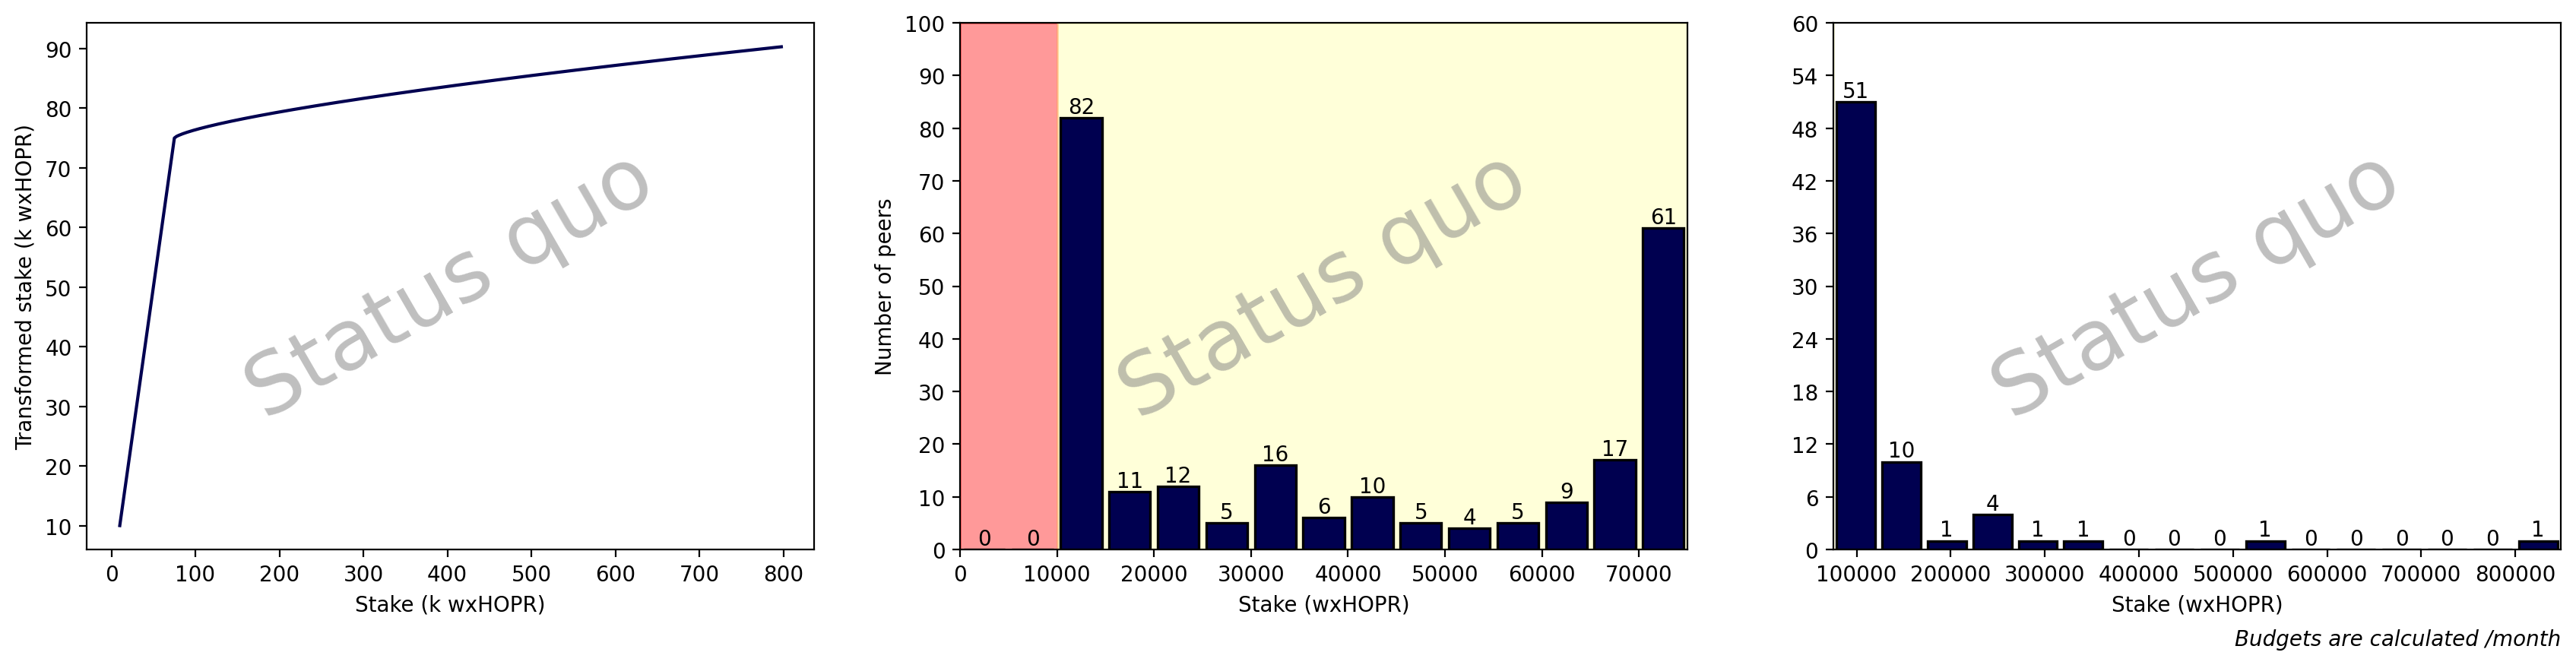

In [5]:
params = [
    IntParameter("bin_count", 15, 5, 30, 1, "Bins count", "1. Histogram"),

    IntRangeParameter("limits", [min_stake_wxhopr, thrs_stake_wxhopr], 0, 500_000, 5_000, "Thresholds", "2. Distribution"),
    FloatParameter("slope", transformation_slope, 0.1, 2.0, 0.1, "Slope", "2. Distribution"),
    FloatParameter("flattening_factor", transformation_flattening_factor, 1.0, 3.0, 0.1, "Flattening factor", "2. Distribution"),

    FloatParameter("target_apr", target_apr, 0.1, 20.0, 0.1, "Target APR", "3. Prices"),
    FloatParameter("token_price", token_price, 0.01, 0.20, 0.001, "Token price ($)", "3. Prices"),

    IntParameter("extra_nodes", 0, 0, 300, 1, "Count", "4. Investors"),
    IntRangeParameter("extra_stake", [250_00, 350_00], 0, 800_00, 25_000, "Stake", "4. Investors"),
    FloatParameter("extra_apr", 1.0, 1.0, 10.0, 0.1, "APR boost", "4. Investors"),
]

model.plot_interactive(params)

### Bringing RPCh in the picture 

In [6]:
packets_outliars = 0.001
hopr_packet_size=400

rpch_requests, rpch_responses = Utils.loadSnapshot(default_snapshot, "rpch_requests_60d", "rpch_responses_60d")
rpch_requests.sort()
rpch_responses.sort()

rpch_requests = rpch_requests[0:int(len(rpch_requests) * (1 - packets_outliars))]
rpch_responses = rpch_responses[0:int(len(rpch_responses) * (1 - packets_outliars))]

req_resp_avg_size = sum(rpch_requests)/len(rpch_requests) + sum(rpch_responses)/len(rpch_responses)
packets_per_comm = req_resp_avg_size/hopr_packet_size
requests_per_day = len(rpch_requests)/60
packets_per_day = requests_per_day * packets_per_comm

print(f"Average RPCh request and response size: {req_resp_avg_size:.2f} bytes")
print(f"Average packets per request/response: {packets_per_comm:.2f}")
print(f"Packets per day: {packets_per_day:_.2f} -> {requests_per_day:_.2f} requests per day")


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
budget = 10526
token_price = 0.10
ticket_price = 0.01
relay_success_rate = 0.985

In [ ]:
ct_packets = budget / 30 / token_price / ticket_price - packets_per_day

print("Current throughput shouldn't change")
print("-"*100)
print("rpch_packets + ct_packets = budget / token_price / ticket_price")
print( "\t-> ct_packets  = budget / token_price / ticket_price - rpch_packets")
print(f"\t               = {budget} / 30 / {token_price} / {ticket_price} - {packets_per_day:_.2f}")
print(f"\t               = {ct_packets:_.2f} messages / day")
print("-"*100)

In [ ]:
rpch_request_price = (ct_packets/ packets_per_day + 1) * ticket_price * packets_per_comm
rpch_plan = round((rpch_request_price*token_price * 2000)/5 + 0.5) * 5

print("RPCh margin should be greater than the cost of CT")
print("-"*100)
print("rpch_revenue - rpch_cost > ct_cost")
print("\t-> rpch_packets / packets_per_request * request_price - rpch_packets * ticket_price > ct_packets * ticket_price")
print("\t-> rpch_packets * (request_price / packets_per_request / ticket_price - 1) > ct_packets")
print("\t-> request_price > (ct_packets / rpch_packets + 1) * ticket_price * packets_per_request")
print(f"\t                 > ({ct_packets:_.2f} / {packets_per_day:_.2f} + 1) * {ticket_price} * {packets_per_comm:_.2f}")
print(f"\t                 > {rpch_request_price:_.4f} wxHOPR")
print(f"\t                 > {rpch_request_price*token_price:_.4f} $")
print("-"*100, end="\n\n")

print(f"RPCh plan should cost at least: {rpch_plan:_.2f}$/2000req.")